In [1]:
! git lfs install
! git clone https://github.com/timojl/clipseg
! pip install diffusers -q
! pip install transformers -q -UU ftfy gradio
! pip install git+https://github.com/openai/CLIP.git -q

Git LFS initialized.
Cloning into 'clipseg'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 232 (delta 72), reused 58 (delta 58), pack-reused 147 (from 1)
Receiving objects: 100% (232/232), 1.40 MiB | 14.06 MiB/s, done.
Resolving deltas: 100% (126/126), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.6 MB/s eta 0:00:00
  Prep

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
%cd clipseg
! ls

/content/clipseg
clip_masking_lvis_image_ids.yml  LICENSE		  score.py
datasets			 metrics.py		  setup.py
environment.yml			 models			  supplementary.pdf
evaluation_utils.py		 overview.png		  Tables.ipynb
example_image.jpg		 Quickstart.ipynb	  training.py
experiments			 README.md		  Visual_Feature_Engineering.ipynb
general_utils.py		 sample_rd64.png
__init__.py			 sample_rd64_refined.png


In [4]:
import torch
import requests
import cv2
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

from io import BytesIO
from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline
from diffusers.schedulers import LMSDiscreteScheduler # Import LMSDiscreteScheduler

In [5]:
# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();


100%|███████████████████████████████████████| 335M/335M [00:14<00:00, 24.4MiB/s]


In [6]:
# !pwd
# !ls -alht
! wget https://huggingface.co/spaces/multimodalart/stable-diffusion-inpainting/resolve/main/clipseg/weights/rd64-uni.pth
!mkdir -p weights; mv rd64-uni.pth weights/
# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('/content/clipseg/weights/rd64-uni.pth', map_location=torch.device('cuda')), strict=False);

--2025-03-30 07:38:31--  https://huggingface.co/spaces/multimodalart/stable-diffusion-inpainting/resolve/main/clipseg/weights/rd64-uni.pth
Resolving huggingface.co (huggingface.co)... 13.35.202.34, 13.35.202.97, 13.35.202.121, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.34|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/23/98/23980d5da66684f76f55cf0ee36831158cb557ca5e3afa167b18872294ab23ba/13845f6cee4d54ca46f62ee19dd354822094a26e0efccc64e606be93d6a7e26f?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27rd64-uni.pth%3B+filename%3D%22rd64-uni.pth%22%3B&Expires=1743323911&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MzMyMzkxMX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8yMy85OC8yMzk4MGQ1ZGE2NjY4NGY3NmY1NWNmMGVlMzY4MzExNThjYjU1N2NhNWUzYWZhMTY3YjE4ODcyMjk0YWIyM2JhLzEzODQ1ZjZjZWU0ZDU0Y2E0NmY2MmVlMTlkZDM1NDgyMjA5NGEyNmUwZWZjY2M2NGU2MDZiZTkzZDZhN2UyNm

In [7]:
# or load from URL...
image_url = 'https://okmagazine.ge/wp-content/uploads/2021/04/00-promo-rob-pattison-1024x1024.jpg' #'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimage.tmdb.org%2Ft%2Fp%2Foriginal%2F72xYNWRTVMDiKVa6SVu6EY0S9Np.jpg' #'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png'
input_image = Image.open(requests.get(image_url, stream=True).raw)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((512, 512)),
])
img = transform(input_image).unsqueeze(0)

In [8]:
%cd ..

/content


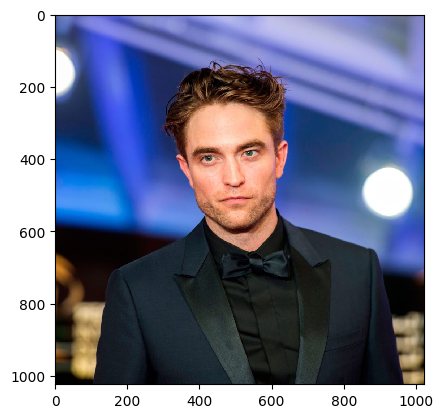

In [9]:
input_image.convert("RGB").resize((512, 512)).save("init_image.png", "PNG")
plt.imshow(input_image, interpolation='nearest')
plt.show()

In [10]:
prompts = ['face']

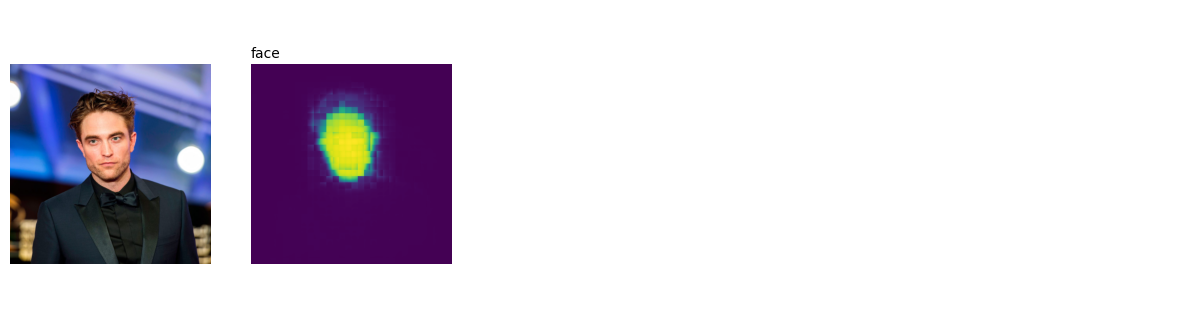

In [11]:

# predict
with torch.no_grad():
    preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]

# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

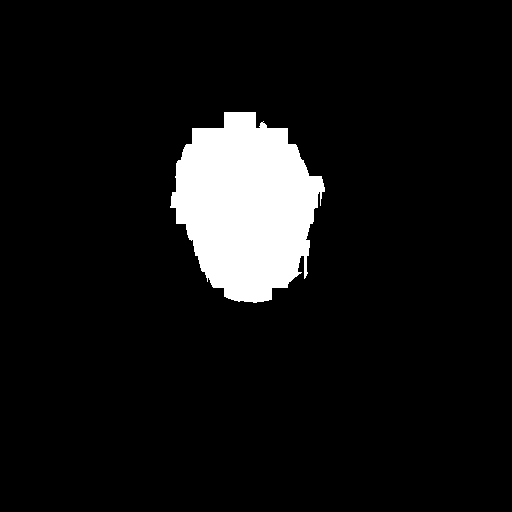

In [12]:
filename = f"mask.png"
plt.imsave(filename,torch.sigmoid(preds[0][0]))

img2 = cv2.imread(filename)
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# For debugging only:
cv2.imwrite(filename,bw_image)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)

In [18]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="main", # Changed the revision to main
    torch_dtype=torch.float16,
    scheduler=LMSDiscreteScheduler.from_config(
        "runwayml/stable-diffusion-inpainting", subfolder="scheduler"
    ),
    use_auth_token=True
).to("cuda")

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_lms_discrete.LMSDiscreteScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to acc

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionInpaintPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [19]:
# Load images and preprocess them
init_image = Image.open('init_image.png').convert("RGB").resize((512, 512))
mask = Image.open('mask.png').convert("L").resize((512, 512))

  0%|          | 0/20 [00:00<?, ?it/s]

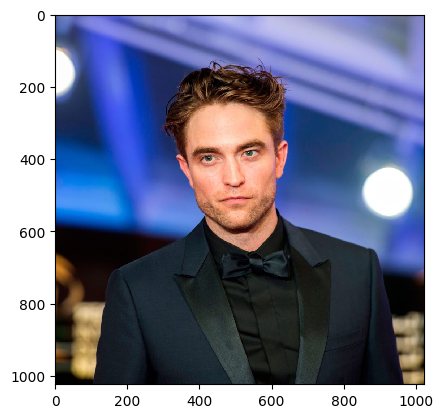

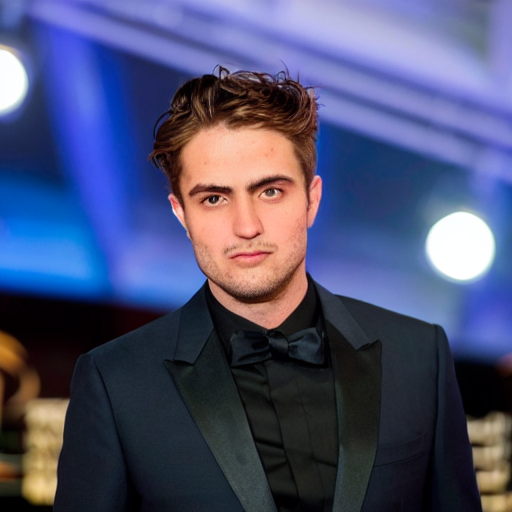

In [24]:
# with autocast("cuda"):
#     images = pipe(prompt="muslim with pimples", init_image=init_image_fixed, mask_image=mask_fixed, strength=0.8)["sample"]

# Run the pipeline with specific data types
with torch.autocast("cuda"):
    images = pipe(
        prompt="muslim with pimples",
        image=init_image, # Renamed init_image_fixed to image
        mask_image=mask,   # Renamed mask_fixed to mask_image
        strength=0.4,
        # num_inference_steps=50, # Reduce inference steps for faster debugging
        # guidance_scale=7.5      # Adjust guidance scale for potentially better results
    )["images"]

plt.imshow(input_image, interpolation='nearest')
plt.show()
images[0]
